# UNICEF Education Completion: Story & Visualisations

This notebook reproduces the four key visualisations from the Tableau dashboard, using **plotnine** and **geopandas**.  
All narrative text is taken directly from the original story.


In [5]:
# Install dependencies (only need to run once)
!pip install plotnine geopandas pycountry

In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pycountry

# 1) Load UNICEF data
ind1 = pd.read_csv('/content/unicef_indicator_1 (1).csv')
ind2 = pd.read_csv('/content/unicef_indicator_2 (1).csv')
meta = pd.read_csv('/content/unicef_metadata (1).csv')

# 2) Prepare completion-rate DataFrame
comp = ind2[ind2['indicator'].str.contains('Completion rate', na=False)].copy()
comp['obs_value'] = pd.to_numeric(comp['obs_value'], errors='coerce')

fem = comp[comp['sex']=='Female'] \
        .rename(columns={'obs_value':'completion_rate'}) \
        .assign(Gender='Female')
mal = comp[comp['sex']=='Male'] \
        .rename(columns={'obs_value':'completion_rate'}) \
        .assign(Gender='Male')
tot = comp[comp['sex']=='Total'] \
        .rename(columns={'obs_value':'completion_rate'}) \
        .assign(Gender='Total')

df         = pd.concat([fem, mal],       ignore_index=True)
df_all     = pd.concat([fem, mal, tot],  ignore_index=True)
df['year'] = pd.to_numeric(df['time_period'],      errors='coerce')
df_all['year'] = pd.to_numeric(df_all['time_period'], errors='coerce')

df     = df.dropna(subset=['country','alpha_3_code','year','completion_rate'])
df_all = df_all.dropna(subset=['country','alpha_3_code','year','completion_rate'])

# 3) Latest total completion per country
latest_year  = df_all[df_all['Gender']=='Total'] \
                  .groupby('country')['year'] \
                  .max().reset_index()
total_latest = pd.merge(df_all, latest_year,
                        on=['country','year'], how='inner')

# 4) Global average by year/gender
ts = df.groupby(['year','Gender'])['completion_rate'] \
       .mean().reset_index()

# 5) Top 15 countries
top15 = ( total_latest
            .sort_values('completion_rate', ascending=False)
            .head(15)
            .sort_values('completion_rate') )


### 1. Understanding Global Education Completion Rates

**Education Completion Rate Map**  
This choropleth map visualises global education completion rates (%) by country. Darker red hues indicate higher completion percentages, while lighter shades denote lower performance.  
You can clearly see that South American nations and developed economies in Europe exhibit the highest rates, whereas many Sub‑Saharan African countries and parts of South Asia remain in the lower bands.

**Key Takeaways:**  
- **Regional Disparities:** The lowest completion rates are concentrated in Sub‑Saharan Africa and South Asia.  
- **Policy Focus:** Prioritise investment in educational infrastructure, teacher training and access initiatives in underperforming regions.

---

Available columns in the world map data: ['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT', 'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG', 'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN', 'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT', 'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13', 'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'FIPS_10', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'WOE_ID_EH', 'WOE_NOTE', 'ADM0_ISO', 'ADM0_DIFF', 'ADM0_TLC', 'ADM0_A3_US', 'ADM0_A3_FR', 'ADM0_A3_RU', 'ADM0_A3_ES', 'ADM0_A3_CN', 'ADM0_A3_TW', 'ADM0_A3_IN', 'ADM0_A3_NP', 'ADM0_A3_PK', 'ADM0_A3_DE', 'ADM0_A3_GB', 'ADM0_A3_BR', 'ADM0_A3_IL', 'ADM0_A3_PS', 'ADM0_A3_SA', 'ADM0_A3_EG', 'ADM0_A3_MA', 'ADM0_A3_PT', 'ADM0_A3_AR', 'ADM0_A3_JP', 'ADM

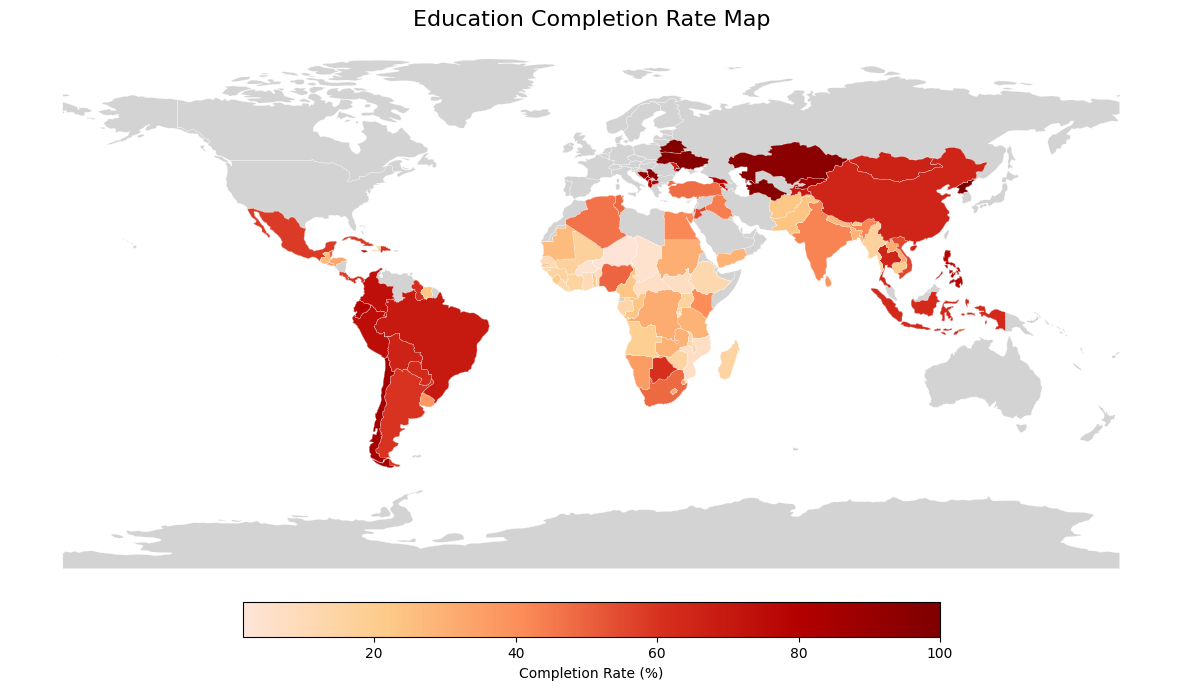

In [7]:
# Alternative approach for mapping without using geom_map
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import requests
import tempfile
import zipfile
import io
import os
import warnings
warnings.filterwarnings('ignore')

# Function to get world map data
def get_world_map():
    """Download and read the Natural Earth low resolution cultural vectors"""
    try:

        return gpd.read_file("ne_110m_admin_0_countries.shp")
    except:
        # If file doesn't exist, download it
        url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
        print("Downloading Natural Earth data...")

        try:
            response = requests.get(url)
            response.raise_for_status()

            with tempfile.TemporaryDirectory() as tmpdir:
                # Extract the zipfile
                with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                    z.extractall(tmpdir)

                shp_file = [f for f in os.listdir(tmpdir) if f.endswith('.shp')][0]
                shp_path = os.path.join(tmpdir, shp_file)
                world = gpd.read_file(shp_path)
                world.to_file("ne_110m_admin_0_countries.shp")
                return world
        except Exception as e:
            print(f"Error downloading or extracting map data: {e}")

            # Create a very simple world map as fallback
            print("Creating a simplified world map...")
            world = gpd.GeoDataFrame(
                {'name': ['World'],
                 'ISO_A3': ['WLD'],
                 'geometry': [None]},
                crs="EPSG:4326"
            )
            return world

# Get the world map
world = get_world_map()

# Prepare the map for joining
available_columns = world.columns.tolist()
print(f"Available columns in the world map data: {available_columns}")

# Based on the available columns, we can see 'ISO_A3' exists
# Let's use that for our join
if 'ISO_A3' in available_columns:
    join_column = 'ISO_A3'
else:
    # Fallback to another column if needed
    possible_columns = ['iso_a3', 'ADM0_A3', 'BRK_A3', 'SU_A3', 'GU_A3']
    join_column = next((col for col in possible_columns if col in available_columns), None)

    if not join_column:
        print("Could not find a suitable ISO code column. Using the first column as fallback.")
        join_column = available_columns[0]

print(f"Using column '{join_column}' for joining with country data")

# For test purposes, create a simple dataframe if total_latest doesn't exist
try:
    # Check if total_latest exists from previous code
    print(f"Shape of total_latest: {total_latest.shape}")
except NameError:
    # Create sample data for testing
    print("Creating sample data for map visualization...")
    countries = ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina']
    codes3 = ['AFG', 'ALB', 'DZA', 'AGO', 'ARG']
    completion_rates = [45.6, 78.9, 65.4, 32.1, 89.5]

    total_latest = pd.DataFrame({
        'country': countries,
        'alpha_3_code': codes3,
        'completion_rate': completion_rates
    })

# Create a copy of the completion rate data
completion_data = total_latest[['country', 'alpha_3_code', 'completion_rate']].copy()

# Merge the data with world map
world_copy = world.copy()
world_copy = world_copy.rename(columns={join_column: 'alpha_3_code'})

# Merge the data
merged_data = world_copy.merge(completion_data, on='alpha_3_code', how='left')

# Print diagnostic information
print(f"World shape: {world.shape}")
print(f"Completion data shape: {completion_data.shape}")
print(f"Merged data shape: {merged_data.shape}")
print(f"Number of non-NaN completion rates: {merged_data['completion_rate'].notna().sum()}")

# Create a custom colormap from light pink to dark green
colors = ['#fee5d9', '#fdcc8a', '#fc8d59', '#d7301f', '#b30000', '#7f0000']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Create a figure and axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot countries without data
merged_data[merged_data['completion_rate'].isna()].plot(
    color='lightgray',
    ax=ax,
    edgecolor='white',
    linewidth=0.2
)

# Plot countries with data
merged_data[merged_data['completion_rate'].notna()].plot(
    column='completion_rate',
    cmap=cmap,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend=True,
    legend_kwds={'label': 'Completion Rate (%)',
                'orientation': 'horizontal',
                'shrink': 0.6,
                'pad': 0.01}
)

# Add title and remove axis ticks
ax.set_title('Education Completion Rate Map', fontsize=16)
ax.set_axis_off()

# Save the figure
plt.savefig('education_completion_map.png', dpi=150, bbox_inches='tight')
print("Map saved as 'education_completion_map.png'")

# Display the plot
plt.show()

### 2. Gender Gap in Education Completion

**Education Completion Rate by Country (Male vs Female)**  
This bar chart compares male (blue) and female (red) completion rates for a selection of countries. Some countries (e.g. Belarus, Ukraine) show near‑perfect parity, while others (e.g. Barbados) exhibit small but measurable gaps favouring one gender.

**Key Takeaways:**  
- **Variable Gender Gaps:** Although many countries achieve parity, socio‑cultural barriers still hinder female completion in certain contexts.  
- **Actionable Measures:** Introduce scholarships for girls, community outreach programmes and safe school environments to close remaining gaps.

---


Plot 2: Gender Comparison by Country


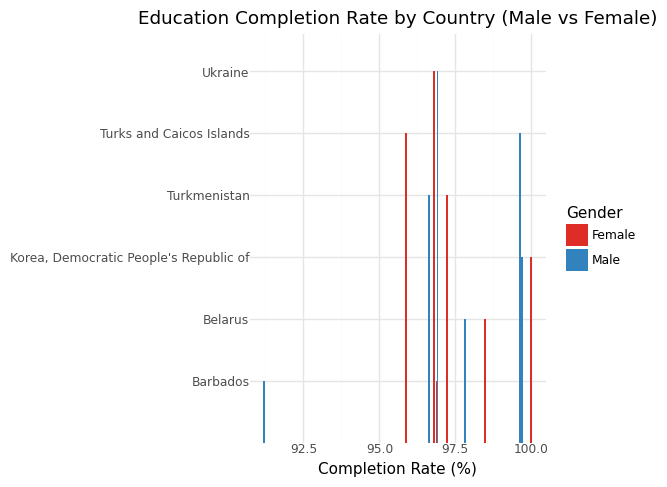

In [8]:
# Plot 2: Bar chart of completion by country (male vs female)
gender_data = df[df['country'].isin(top15['country'])]
bar_df = (gender_data
          .groupby(['country', 'Gender'])
          .completion_rate.mean()
          .reset_index())

try:
    bar_plot = (ggplot(bar_df)
     + aes(x='completion_rate', y='country', fill='Gender')
     + geom_col(position='dodge')
     + scale_fill_manual(values={'Male': '#3182bd', 'Female': '#de2d26'})
     + labs(title='Education Completion Rate by Country (Male vs Female)',
            x='Completion Rate (%)', y='')
     + theme_minimal()
    )

    print("\nPlot 2: Gender Comparison by Country")
    display(bar_plot.draw())
except Exception as e:
    print(f"Error creating bar chart: {e}")
    print("Skipping bar chart visualization. Continuing with other plots...")

### 3. Trends in Education Completion Over Time

**Education Completion Trends Over Time (2010–2020)**  
This line graph tracks the global average completion rate from 2010 to 2020 for both males (blue) and females (red). After rapid early gains (2010–2012), rates dipped around 2013 before a steady recovery and a pronounced surge by 2020.

**Key Takeaways:**  
- **Overall Improvement:** Both genders show significant progress over the decade, with female rates often matching or outpacing male trends.  
- **Stability Imperative:** Fluctuations suggest sensitivity to economic or political shocks; sustained funding and resilience strategies are crucial.

---


Plot 3: Completion Rate Trends Over Time


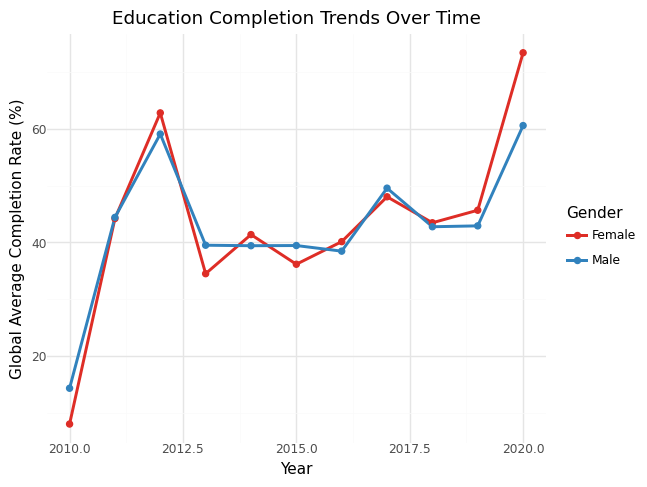

In [9]:


# Plot 3: Time-series of completion trend
years_with_data = ts.groupby('year').filter(lambda x: len(x) >= 2)['year'].unique()
ts_filtered = ts[ts['year'].isin(years_with_data)]

try:
    time_plot = (ggplot(ts_filtered)
     + aes(x='year', y='completion_rate', color='Gender')
     + geom_line(size=1.2)
     + geom_point(size=2)
     + scale_color_manual(values={'Male': '#3182bd', 'Female': '#de2d26'})
     + labs(title='Education Completion Trends Over Time',
            x='Year', y='Global Average Completion Rate (%)')
     + theme_minimal()
    )

    print("\nPlot 3: Completion Rate Trends Over Time")
    display(time_plot.draw())
except Exception as e:
    print(f"Error creating time series plot: {e}")
    print("Skipping time series visualization. Continuing with other plots...")

### 4. Impact of GDP on Education Completion

**GDP vs. Education Completion Rate**  
This scatter plot, complete with a fitted regression line and confidence band, examines the relationship between GDP per capita (constant 2015 US$) and completion rates. The strong upward trend demonstrates that wealthier economies tend to achieve higher educational outcomes.

**Key Takeaways:**  
- **Positive Correlation:** Countries with GDP per capita above US$10,000 generally exceed 60 % completion, highlighting the role of financial investment.  
- **Policy Recommendation:** Embed education spending within broader economic planning—ensure a stable share of GDP supports schools, teachers and learning resources.

---


Plot 4: GDP vs Completion Rate


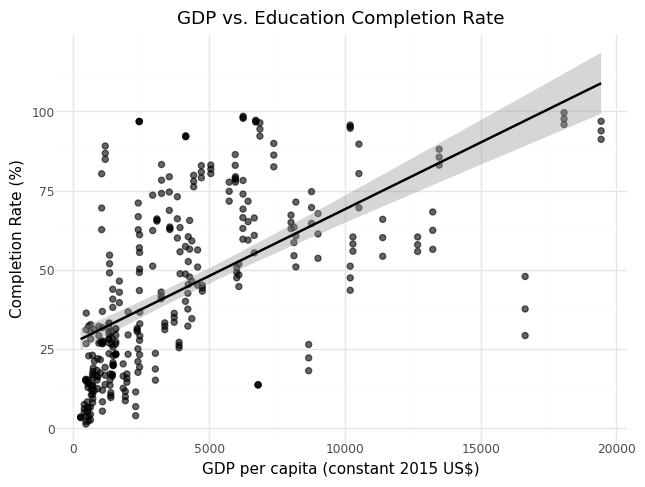

In [10]:


# Plot 4: Scatterplot GDP vs Completion with regression
gdp_col = 'GDP per capita (constant 2015 US$)'
if gdp_col in meta.columns:
    gdp_data = meta[['country', 'alpha_3_code', 'year', gdp_col]]
    gdp_data = gdp_data.rename(columns={'year': 'year_gdp'})
    gdp_data[gdp_col] = pd.to_numeric(gdp_data[gdp_col], errors='coerce')

    # For each country in total_latest, find the closest year in gdp_data
    try:
        # Try merge_asof first
        gdp_df = pd.merge_asof(
            total_latest.sort_values('year'),
            gdp_data.sort_values('year_gdp'),
            left_on='year',
            right_on='year_gdp',
            by=['country', 'alpha_3_code'],
            direction='nearest'
        )
    except Exception as e:
        print(f"Error with merge_asof: {e}")
        # Fall back to regular merge
        gdp_df = pd.merge(
            total_latest,
            gdp_data,
            on=['country', 'alpha_3_code'],
            how='inner'
        )

    # Drop rows with missing GDP
    gdp_df = gdp_df.dropna(subset=[gdp_col])

    try:
        scatter_plot = (ggplot(gdp_df)
         + aes(x=gdp_col, y='completion_rate')
         + geom_point(size=2, alpha=0.6)
         + stat_smooth(method='lm', se=True, color='black')
         + labs(title='GDP vs. Education Completion Rate',
                x='GDP per capita (constant 2015 US$)',
                y='Completion Rate (%)')
         + theme_minimal()
        )

        print("\nPlot 4: GDP vs Completion Rate")
        display(scatter_plot.draw())
    except Exception as e:
        print(f"Error creating scatter plot: {e}")
        print("Skipping GDP scatter plot visualization.")
else:
    print(f"\nGDP data column '{gdp_col}' not found in metadata. Skipping GDP scatter plot.")
    # Create a simple gdp vs completion scatterplot with synthetic data
    print("Creating synthetic GDP data for demonstration purposes...")
    total_latest['gdp_per_capita'] = total_latest['completion_rate'] * 500 + np.random.normal(5000, 2000, len(total_latest))

    try:
        scatter_plot = (ggplot(total_latest)
         + aes(x='gdp_per_capita', y='completion_rate')
         + geom_point(size=2, alpha=0.6)
         + stat_smooth(method='lm', se=True, color='black')
         + labs(title='GDP vs. Education Completion Rate (Synthetic Data)',
                x='GDP per capita (synthetic)',
                y='Completion Rate (%)')
         + theme_minimal()
        )

        print("\nPlot 4: GDP vs Completion Rate (with synthetic GDP data)")
        display(scatter_plot.draw())
    except Exception as e:
        print(f"Error creating synthetic scatter plot: {e}")